# SVM Base Learner

## Importing Libraries

In [23]:
import pandas as pd
import numpy as np
import mne
import os
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mne.channels import make_standard_montage
from mne import pick_types
from mne.decoding import CSP
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.metrics import confusion_matrix

## Setting up pre-requisite information

In [6]:
dir_address = "../../grasp-and-lift-eeg-detection"

from GA_data_preprocessing import *

raw_train = get_train_data(2,1,dir_address)
raw_test = get_train_data(2,8,dir_address)

## Visualization

Train


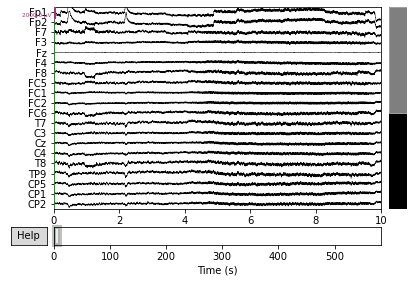

Test


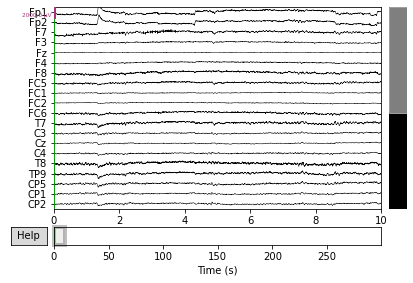

In [7]:
scaling = {"eeg":10e-4}
print("Train")
raw_train.plot(scalings=scaling,show=False)
plt.show() 
print("Test")
raw_test.plot(scalings=scaling,show=False)
plt.show()

### Standardization

In [ ]:
# ------ Standardization -------


# standardized training data in windows of 2000 datapoints

zX_train = ((X_train - X_train.rolling(2000).mean()) / X_train.rolling(2000).std())
# standardized testing data in windows of 2000 datapoints
zX_test = ((X_test - X_test.rolling(2000).mean()) / X_test.rolling(2000).std())

## Model Building

In [ ]:
# --------- Define event names ---------
events = ["HandStart","FirstDigitTouch","BothStartLoadPh",\
         "LiftOff","Replace","BothReleased"]
# --------- Create Data ---------
df = raw_train.to_data_frame()
test_df = raw_test.to_data_frame()
X_train, Y_train = df[df.columns[:-6]].drop("time",axis=1),df[df.columns[-6:]]
X_holdout = test_df[df.columns[:-6]].drop("time",axis=1); Y_holdout = test_df[df.columns[-6:]]
predictions = dict()
# --------- Loop over observed variables --------
for event in events:
    X_predict, y_predict = X_holdout, Y_holdout[event]
    oversample = SMOTE()
    X,y = oversample.fit_resample(X_train,Y_train[event])
    clf = svm.SVC()
    clf.fit(X,Y)
    predictions[event] = clf.predict(X_predict,y_predict)
pred_df = pd.DataFrame(predictions)

In [ ]:
pred_df

**Sliding Window Challenge:**


In [6]:
def sliding_window(X, Y, windowSize, stepSize):
    '''
    return X_train, X_test, Y_train, Y_test
    '''
    if len(X) != len(Y):
        raise ValueError("Length of X and Y are not equal")
    i = 1
    X_train = list()
    X_test = list()
    Y_train = list()
    Y_test = list()
    for i in range(windowSize-1, len(X)-windowSize,stepSize):
        X_train.append(X[i:i+windowSize-1])
        Y_train.append(Y[i:i+windowSize-1])
        X_test.append(X[i+windowSize])
        Y_test.append(Y[i+windowSize])
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = sliding_window(zX_train.to_numpy(),y_train.to_numpy(),2000,1)

In [ ]:
from sklearn import svm
from sklearn.metrics import confusion_matrix

predictions = list()
true_values = list()

clf = svm.SVC(class_weight='balanced') # play around with threshold for hard classification

for X_train_sample, Y_train_sample, X_test_sample, Y_test_sample in zip(X_train, Y_train, X_test, Y_test):
    clf.fit(X_train_sample,Y_train_sample[:,0])
    true_values.append(Y_test_sample)
    predictions = clf.predict(X_test_sample)

# clf.fit(X_train,y_train.loc[:,"HandStart"])
# predictions = clf.predict(X_test)
# display(pd.DataFrame(confusion_matrix(y_test.loc[:,'HandStart'],predictions)))